<a href="https://colab.research.google.com/github/sujithgunturu/colabtogit/blob/main/Jacobean_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from scipy import interpolate
from scipy.integrate import odeint
import autograd.numpy as np
import autograd
from scipy.stats import multivariate_normal 
from scipy.integrate import solve_ivp

In [ ]:
"""Model Class Definition"""
class Model(object):
    
    #Attributes we want each instance of model to have
    def __init__(self,Eqns):
        self.Eqns = Eqns  #
        #self.n_var = len(Eqns)
        self.solution=[]  # creates a new empty list for each model
        self.params=None   # Initialize parameter values
        
        self.y0=None      # Initialze initial state variables
        
        self.t=None       # Initialie array of times at which solutions are sought
        
        self.Env=None     # Set flag that the simulation environment is not yet defined
                          #    When it is, it will most likely be an array with one
                          #    row per measurement time and one column per environmental
                          #    variable.
        self.day_length=None
        
                    
    # Store a vector of desired solution times
    def new_soltimes(self,t):
        self.t=np.array(t)
    
    # Store a vector of desired state variable initial conditions
    def new_ICs(self,y0):
        self.y0=np.array(y0)
    
    # Store a vector of model parameters - this is used during parameter estimation
    def new_params(self,params):
        self.params=np.array(params)
        
    
    """ The following two methods are overloaded in the users class definition """
    
    # Fetch the environmental information from a file.  "Environ" is 
    # whatever information is needed to do this.
    def FetchEnviron(self,Environ):
        pass
        
    
  
    def GetEnvData(self,t):
        self.Edat=np.zeros(9)
        
        
    # Run the model
    def Run(self,ICs=None,params=None,t=None,Environ=None):
        
        # Perform any needed initializations
        if ICs is not None    : self.new_ICs(ICs)
        if params is not None : self.new_params(params)
        if t is not None      : self.new_soltimes(t)
        #if Environ is not None: self.FetchEnviron(Environ)
        
        # if self.params is None or self.y0 is None or self.t is None or self.Env is None:
        #     raise Exception("Prequisite data for run is incomplete")
        
        # Define the function that is passed to odeint
        self.count = 0
        def deriv(y,t,model):
            
            # Obtain the environmental data for this value of t
            #self.Edat
            # Compute required derivatives.  This will entail using data that
            # should be ready and waiting in model.par and model.Edat

            return model.Eqns(t, y, model.params, model)
            


        # Call odeint to itegrate diffeq system.  All the odeint arguments are shown
        # here in case we want to modify something in a future version.  (It is, perhaps,
        # noteworthy that some of the extra parameters apparenly specify the order of 
        # integration to be peformed.)
        
        return odeint(deriv,           # Computes the derivative of y at t
                      self.y0,         # Initial condition on y (can be a vector) 
                      self.t,          # The time points for which to solve for y
                      args=(self,),    # Extra arguments to pass to function (self reference to
                                       #   this model instance)
                      Dfun=None,       # Gradient (Jacobian) of func 
                      col_deriv=0,     # True if Dfun defines derivatives down columns
                      full_output=0,   # True if to return a dictionary of 
                                       #   optional outputs as the second output
                      printmessg=0,    # Whether to print the convergence message
                      tfirst=False,    # If True, the first two arguments of func 
                                       #   (and Dfun, if given) must t, y
                                
        #  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
        #     ror the definition of these arguments
        
                      ml=None,           
                      mu=None, 
                      rtol=None, 
                      atol=None, 
                      tcrit=None, 
                      h0=0.0, 
                      hmax=0.0, 
                      hmin=0.0, 
                      ixpr=0, 
                      mxstep=0, 
                      mxhnil=0, 
                      mxordn=12, 
                      mxords=5, 
                      )

In [ ]:
class osu_model(Model):
    def __init__(self,Eqns):
        Model.__init__(self,Eqns)
        #self.n_var = Model.n_var
    def FetchEnviron(self, Environ):
      #for osu model do: pass
      pass

       
       



In [ ]:
class Build_Jacobean(Model):
    def __init__(self, system, statevars, statevars0, parameters, paramvalues):
      self.system = system
      self.statevars = statevars
      self.statevars0 = statevars0
      self.parameters = parameters
      self.paramvalues = paramvalues

    def Run_Model(self, environ, t):
        self.Modelinstace= osu_model(self.system)
        self.Modelinstace.new_ICs(self.statevars0[:len(self.statevars)])
        self.Modelinstace.new_soltimes(t)
        self.Modelinstace.new_params(self.paramvalues)

        Jac_X = autograd.jacobian(self.system,argnum=1)
        Jac_P = autograd.jacobian(self.system,argnum=2)
        
        P = self.paramvalues
        n_vars = len(self.statevars)
        n_params = len(self.parameters)
        n_depend = n_vars*n_params
        def rhs_fn(X,t):                                    #for odeint
        #def rhs_fn(t,X):                                   #for solve_ivp
            # split into variables and parameter derivatives
            Xv = X[:n_vars]
            Xd = X[n_vars:].reshape((n_vars,n_params))

          # initialize the derivative vector
            d = np.zeros_like(X)
            # copy the original ODE part
            print("t in rhs_fn", t)
            d[:n_vars] = self.system(t,Xv,P, self.Modelinstace)
            JX = Jac_X(t, np.array(Xv), np.array(P), self.Modelinstace)
            JP = Jac_P(t, np.array(Xv), np.array(P), self.Modelinstace)
            # find the RHS for the parameter derivatives and reflatten to a vector
            d[n_vars:] = (JX.dot(Xd) + JP).flatten()

            return d
        # initial conditions
        x0 = self.statevars0
        # solve the odes
        
        #soln = solve_ivp(rhs_fn, (t[0],t[-1]), x0, t_eval=t)
        self.solution = odeint(rhs_fn, x0, t)
        
        return self.solution
    def plotjacobeans(self):
      plt.plot(self.solution[:, :len(self.statevars)])
      plt.show()
      for i in range(len(self.statevars)):
        plt.figure()
        plt.title(self.statevars[i])
        plt.plot(solution[:, len(self.statevars) + i*len(self.parameters): len(self.statevars) + i*len(self.parameters) + len(self.parameters)])
        forlabel = []
        for param in self.parameters:
          forlabel.append(str(self.statevars[i]) +"_"+ str(param))
        plt.legend(forlabel, bbox_to_anchor=(1.05, 1))
        plt.show()


    def Test(self, Test_Number=1,info = tuple()):
      model_outputs = info[0]
      var_param_list = info[1]
      numberofpartials = len(self.statevars) * len(self.parameters)

      for parial in range(numberofpartials):
        plt.plot(model_outputs[:, len(self.statevars) + parial])
      #positive run
      self.paramvalues = self.paramvalues * 1.03
      thetapos = self.Run_Model("", t)
      # negative run
      self.paramvalues = self.paramvalues * 0.9708
      thetaneg = self.Run_Model("", t)
      deltam_deltatheta = (thetapos[len(self.statevars):] - thetaneg[len(self.statevars):])/0.06
      plt.plot(deltam_deltatheta, "--b")

In [ ]:
OneEx =lambda x: 1.+np.exp(x)
OvrEx =lambda x: 1./(OneEx(x))
MvrEx =lambda x: 1.-(OvrEx(x))
LinEx =lambda x1,x2: x1+np.exp(x2)-1  # Saturation vapor pressure (Teten's eq'n)
SatVP =lambda x: 0.6108*np.exp(17.27*x/(x+c_CT))
c_fwt=np.log(99)/0.175
c_Dt =4098
c_CT =237.3        # This appears in the FAO56 - it's NOT 273.16 typo-ed
c_CK =273.16       # This is used to convert C --> K 
c_SB =4.9031e-9    # Stefan-Boltzmann constant (MJ K^-4 m^-2 d^-1)
c_alb=0.23         # Albedo
c_Gsc=0.0820       # Solar constant

                   # Winter wheat crop ET coef. - Table 12 FAO 56
ki=0.4; km=1.15; ke=0.25

                    # Manhattan Agronomy North Farm lat, long, Alt
MHK_lat,MHK_lon,MHK_alt=39.208570,-96.591690,332.232000

In [ ]:
class Weather(object):
    
    # Calculate net solar radiation at the crop surface
    def Get_Wnrt(self,RawData):
        
        Wnrt=[]             # Initialize output array
        
        # loop over all records
        for j,rec in enumerate(RawData):
              
            """ Comments in order used by code """
            # Wat  is the average daily temperature at time t
            # Wdt  is the photoperiod at time t                              
            # Wst  is solar radiation at time t                              
            # Wtxt is daily maximum air temperature at 2 meters at time t
            # Wtat is daily average air temperature at 2 meters at time t
            # Wtnt is daily minimum air temperature at 2 meters at time t
            # Wht  is average daily relative humidity at 2 meters at time t
            # Wpt  is average daily air pressure at 2 meters at time t       
            # Wnrt is the net solar radiation at the crop surface at time t
            # Wwt  is the wind speed at 2 meters at time t
            # Wrt  is rainfall at time t
            
            """ Variables in order used in mesonet file """
            Wpt,Wtat,Wtnt,Wtxt,Wht,Wrt,Wst,Wwt,Sris,Sset,Wdt=rec
                            # Max & min temps converted to Kelvin
            TmnK=Wtnt+c_CK; TmxK=Wtxt+c_CK
            
            # Vapor pressure stuff
            Wdpt=Wtnt-2.5   # Approximation for dewpoint temperature
            ea =SatVP(Wdpt) # Actual vapor pressure
            
            # Solar stuff
            J=(j+1)%365                         # Day of year
            S_del=0.409*np.sin(2*np.pi/365*J-1.39)    # Solar declination
            L_rad=(np.pi/180)*MHK_lat              # Latitude in radians
            omg_s=np.arccos(-np.tan(L_rad)*np.tan(S_del))  # Sunset hour angle
            Sinvd=1+0.033*np.cos(2*np.pi/365*J)       # Inv. rel. solar dist.
                                                # Extraterrestrial rad.
            Ra =(24*60/np.pi)*c_Gsc*Sinvd*\
                (omg_s*np.sin(L_rad)*np.sin(S_del)+np.cos(L_rad)*np.cos(S_del)*np.sin(omg_s))
            Rso=(0.75+2e-5*MHK_alt)*Ra          # Clear-sky radiation
            
            # Net radiation
            Rnl=c_SB*((TmxK**4+TmnK**4)/2)*(0.34-0.14*np.sqrt(ea))*\
                      (1.35*Wst/Rso-0.35)
            Rns=(1-c_alb)*Wst
            Rn =Rns-Rnl
            
            # Save this record's net radiation result
            Wnrt+=[Rn]
            
        # Done
        return np.array(Wnrt)
        
    # Read the data from the local directory
    def Get_Data(self,spec=None):
        
        # Read the data
        RawData=np.genfromtxt("MHK_19_20.csv",delimiter=',',skip_header=1,                     
                              missing_values=('M'),filling_values=(999.),
                              usecols=(2,3,4,5,6,7,8,9,10,11))
        
        # Replace mising data values
        I,J=RawData.shape; cnt=0
        for i in range(I):
            for j in range(J):
                if RawData[i,j]==999.:
                    RawData[i,j]=(RawData[i-1,j]+RawData[i+1,j])/2
                    cnt+=1
        
        # Add a column of photoperiods
        PhotoPer=(RawData[:,-1]-RawData[:,-2]).reshape((I,1))
        RawData=np.concatenate((RawData,PhotoPer),axis=1)
        
        # Add a column with the net solar radiation at the crop surface
        Wnrt=self.Get_Wnrt(RawData).reshape((I,1))
        RawData=np.concatenate((RawData,Wnrt),axis=1)
        print(RawData[180,:])

        return RawData

    # Make an instance - Really dumb for now
    def __init__(self):
        self.WX_data=self.Get_Data()
    def WX(self,t):
        
        # A future version of this might allow for continuous time, for
        # example by using a lookup function but not now.
        it=int(t)
        
        """ Get record in file order """
        Wpt,Wtat,Wtnt,Wtxt,Wht,Wrt,Wst,Wwt,Sris,Sset,Wdt,Wnrt=self.WX_data[it]
        Wat=Wtat  # Average daily temp is Wtat, not (Wtxt+Wtnt)/2
        
        """ Return record in internal use order """
        # Wat  is the average daily temperature at time t
        # Wdt  is the photoperiod at time t                              
        # Wst  is solar radiation at time t                              
        # Wtxt is daily maximum air temperature at 2 meters at time t
        # Wtat is daily average air temperature at 2 meters at time t
        # Wtnt is daily minimum air temperature at 2 meters at time t
        # Wht  is average daily relative humidity at 2 meters at time t
        # Wpt  is average daily air pressure at 2 meters at time t       
        # Wnrt is the net solar radiation at the crop surface at time t
        # Wwt  is the wind speed at 2 meters at time t
        # Wrt  is rainfall at time t
        return Wat,Wdt,Wst,Wtxt,Wtat,Wtnt,Wht,Wpt,Wnrt,Wwt,Wrt


In [ ]:
MHK=Weather()

In [ ]:
def rhs(t, X, P, model):
    
    # Unpack state varables
    Svt,Sat,Slt,Sbt,Sgt,Syt,Swt=X
    
    # Unpack parameters
    sxl,th8vr,th8vd,th8vo,th8vs,th8vq,th8ds,th8a,th8dr,\
    th8dm,th8tr,th8td,th8to,th8alf,th8el,th8k,th8sr,th8sm,\
    th8rue,th8m,th8gx,th8gb,th8ts=P
    
    # Obtain weather data for time t
    Wat,Wdt,Wst,Wtxt,Wtat,Wtnt,Wht,Wpt,Wnrt,Wwt,Wrt= MHK.WX(t)


    """                        """
    """ Differential Equations """
    """                        """
    
    """ Cumulative vernalization """
    NuEx  =-th8vr*th8vd
    DeEx1 =-th8vr*(Wat-th8vo+th8vd)
    DeEx2 = th8vr*(Wat-th8vo)
    dSvtdt=OneEx(NuEx)*OvrEx(LinEx(DeEx1,DeEx2))
    
    """ Physiological age """
    #  Vernalization development rate factor
    DeEx1 =-100*(Sat/th8ts-1)
    DeEx2 =-(10/th8vq)*(Svt-th8vq/2)
    GnFac1=MvrEx(DeEx1)                 # Also used under Grain number
    fvt   =1-th8vs*GnFac1*MvrEx(DeEx2)
    
    #  Daylength development rate factor
    DeEx1 =-100*(Sat/th8a-1)
    DeEx2 =-th8dr*(Wdt-th8dm)
    GnFac2=MvrEx(DeEx1)                 # Also used under Grain number & Yield
    fdt   =1-th8ds*GnFac2*MvrEx(DeEx2)
    
    #  Thermal development rate factor
    NuEx =-th8tr*th8td
    DeEx1=-th8tr*(Wat-th8to+th8td)
    DeEx2= th8tr*(Wat-th8to)
    dtt  =OneEx(NuEx)*OvrEx(LinEx(DeEx1,DeEx2))
    
    # Combined rate
    dSatdt=fvt*fdt*dtt
    
    """ Leaf area index """
    DeEx1 =-c_fwt*(Swt-0.175)
    DeEx2 =-100*(Sat/th8el-1)
    DeEx3 =-100*np.exp(-th8k*Slt)+5
    DeEx4 =-th8sr*(Wat/th8sm-1)
    fwt   =OvrEx(DeEx1)
    dSltdt=Slt*(th8alf*dtt*fwt*MvrEx(DeEx2)*OvrEx(DeEx3)-OvrEx(DeEx4))
    
    """ Biomass """
    Nu   =th8rue*Wst*(1-np.exp(-th8k*Slt))*fwt*dtt
    DeEx1=-100*(Sat/th8m-1)
    DeEx2=-100*((1000/th8gx)*(Syt/Sgt)-1)
    dSbtdt=Nu*MvrEx(DeEx1)*MvrEx(DeEx2)
    
    
    """ Grain number """
    dSgtdt=th8gb*dSbtdt*GnFac1*GnFac2
    
    """ Yield """
    GnFac3=(1-GnFac2)                   # Also used under Soil water
    dSytdt=dSbtdt*GnFac3
    
    """ Soil Water """
    Dt=c_Dt*SatVP(Wtat)/(Wtat+c_CT)**2
    est=(SatVP(Wtxt)+SatVP(Wtnt))/2     
    eat=est*Wht/100
    gam_t=6.65e-4*Wpt
    e0t=(0.408*Dt*Wnrt+gam_t*900/(Wtat+c_CT)*Wwt*(est-eat))/\
        (Dt+gam_t*(1+0.34*Wwt))
    
    kmki=km-ki; kike=ki-ke
    kct=ki+(1-np.exp(-th8k*Slt))*(kmki-kike*GnFac3)-kike*GnFac3
    ect=e0t*kct
    
    DeEx1 =-100*(Swt/sxl+1)
    dSwtdt=Wrt*OvrEx(DeEx1)-ect*fwt
    
    """ Pack up and go home """
    dSVdt=np.array([dSvtdt,dSatdt,dSltdt,dSbtdt,dSgtdt,dSytdt,dSwtdt])
    return dSVdt

In [ ]:
ICs = [0.0, 0.0, 0.009865234375, 0.50263671875, 9.896484375000001e-16, 0.0, 75.2197265625]
sxl = 150.      # Value from OK_1 model; OK_2 value causes div by zero
th8vr = -0.28
th8vd = 5
th8vo = 4
th8vs = 0.975   # Shrunk from 1 so +-2.5% swing does not exceed 1
th8vq = 42      # Value from OK_1 model; OK_2 value causes div by zero
th8ds = 0.8
th8a = 20       # Reduced from 36 because Sat seems reduced
th8dr = 0.44
th8dm = 10.67
th8tr = 0.14
th8td = -7.6
th8to = 24
th8alf= 0.30
th8el = 18
th8k = 0.75
th8sr = 10
th8sm = 35
th8rue = 1.15
th8m = 60
th8gx = 45
th8gb = 20
th8ts = 10      

paramvals=np.array([sxl,th8vr,th8vd,th8vo,th8vs,th8vq,th8ds,th8a,th8dr,
                th8dm,th8tr,th8td,th8to,th8alf,th8el,th8k,th8sr,th8sm,
                th8rue,th8m,th8gx,th8gb,th8ts])


In [ ]:
osu= osu_model(rhs)
osu.new_ICs(ICs)
t = np.linspace(243, 486, 244)
osu.new_soltimes(t)
osu.new_params(paramvals)
soln = osu.Run()
import matplotlib.pyplot as plt
# _ = plt.plot(soln)
  

In [ ]:
variables = ('S_vt','S_at', 'S_lt','S_bt', 'S_gt', 'S_yt', 'S_wt')
parameters  = ('theta_vr', 'theta_vd', 'theta_vo', 'theta_vs', 'theta_vq', 'theta_ps', 'theta_pr', 'theta_pm','theta_tr',
              'theta_td', 'theta_t0', 'theta_alpha', 'theta_el', 'theta_k', 'theta_sr', 'theta_sm','theta_gx','theta_m',
              'theta_gb', 'theta_ts', 'theta_rue', 'theta_a', 'S_xl')



params0 = [0.]*len(variables)*len(parameters)
t = np.linspace(0., 100., 100)
osujacobean  = Build_Jacobean(rhs, variables, ICs + params0, parameters, paramvals )
solution = osujacobean.Run_Model(['Weather_data_2020.csv'], t) 
_ = plt.plot(solution.T[7:].T)


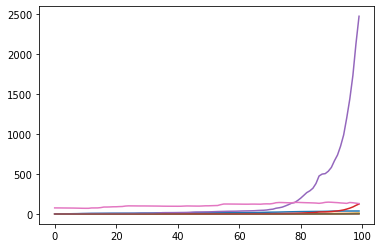

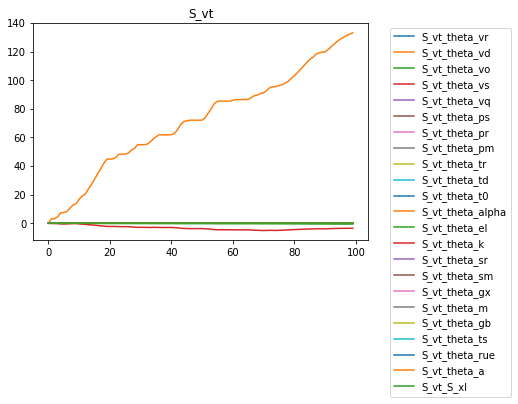

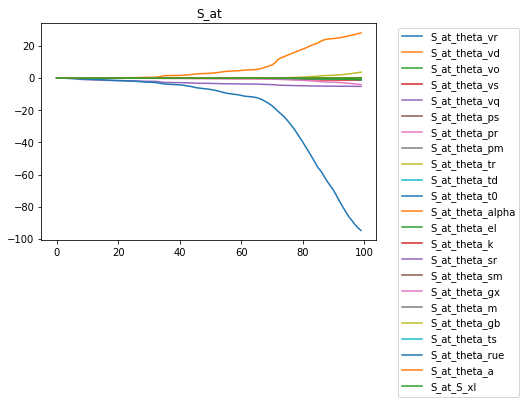

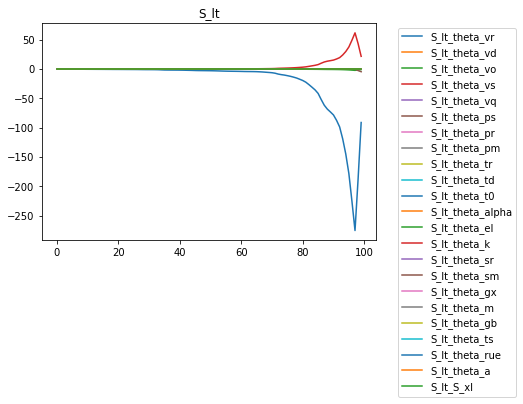

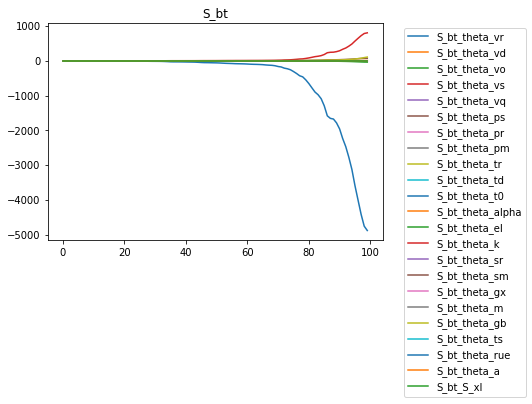

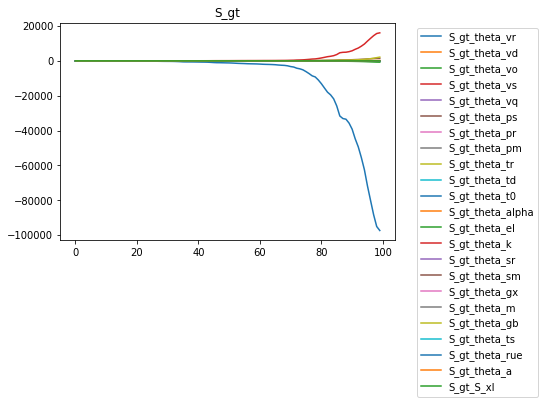

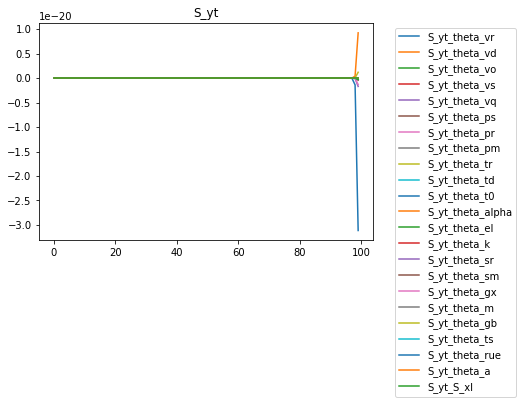

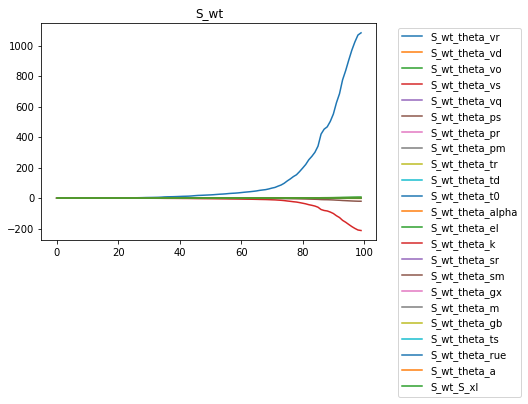

In [ ]:
osujacobean.plotjacobeans()

In [ ]:
class Generate_Fisher_Matrix(Build_Jacobean):
    def __init__(self, environments=[[]],covmatrix=None, betavector=0, w=np.linspace(0, 100, 100)):

        Build_Jacobean.__init__(self, rhs,variables, ICs + params0, parameters, paramvals)
        self.environments = environments
        self.covmatrix = np.array(covmatrix)
        self.betavector = np.array(betavector)
        self.w = w
    def Simulate(self, ICs, paramvals, t):
        simulation = []
        for environment in self.environments:
          soln = self.Run_Model(environment, t)
          simulation.append(soln)
        self.simulation = np.array(simulation)
        return self.simulation
       
    def Residuals(self, i):
        mean = [0.]*self.covmatrix.shape[0]
        modeloutput_i = self.simulation[0][i, :len(ICs)]
        diagonalmatrix_beta_2 =  np.diag(np.power(modeloutput_i, self.betavector/2))
        res = diagonalmatrix_beta_2@np.linalg.inv(self.covmatrix)@diagonalmatrix_beta_2
        self.randomvectors = np.random.multivariate_normal(mean, res, len(w)) 
         
        return self.randomvectors
        

    def du_dr_i(self,i):
        summationarray = []
        q = self.covmatrix.shape[0]
        
        for index1 in range(q):
          for index2 in range(q):
            m1 = np.power(self.simulation[0][i][index1], (self.betavector/2))
            m2 = np.power(self.simulation[0][i][index2], (self.betavector/2))
            v = np.linalg.inv(self.covmatrix)
            m = m1 * m2
            #for l in range(q):
              #do something
            r = self.Residuals(i)[i]
            prod =   m*v[index1][index2]*r
          summationarray.append(prod)
        self.dudri = np.sum(summationarray, axis = 1)
        return self.dudri 

    def da_dth8_k_div_a(self, k, i):
         q = self.covmatrix.shape[0]
         term = 0.5 * (2 * np.pi)**q/2 * np.linalg.det((np.linalg.inv(self.covmatrix)))**-0.5 
         #dmdthetaarr = self.simulation[0][i][len(ICs)+k::len(paramvals)]
         dmdthetaarr = self.simulation[0][i][len(ICs):].reshape((-1, len(paramvals)))[:, k]
         summationarray = []
         
         for index in range(q):
           summationarray.append(dmdthetaarr[index]/self.simulation[0][i][index])
         
         self.dudth8kdiva = term *np.sum(summationarray)
         
         return self.dudth8kdiva
   
    def du_dth8_k(self, k, i):
        summation = []
        q = self.covmatrix.shape[0]
        #dmdthetaarr = self.simulation[0][k][len(ICs):]
        # dmdthetaarr = self.simulation[0][i][len(ICs)+k::len(paramvals)]
        dmdthetaarr = self.simulation[0][i][len(ICs):].reshape((-1, len(paramvals)))[:, k]
        for index1 in range(q):
          for index2 in range(q):
            beta_xi = self.betavector[index1]
            #should do the inverse or T
            m_xi_beta_inv = np.power(self.simulation[0][i][:q], self.betavector/2)[index1]
            dmdtheta_xi = dmdthetaarr[index1]
            m_sigma_beta = np.power(self.simulation[0][i][:q], self.betavector/2)[index2]
            
            
            beta_sigma = self.betavector[index2]
            m_sigma_beta_inv = np.power(self.simulation[0][i][:q], self.betavector/2)[index2]
            dmdtheta_sigma = dmdthetaarr[index2]
            m_xi_beta = np.power(self.simulation[0][i][:q], self.betavector/2)[index1]
            
            term = (( (beta_xi * m_xi_beta_inv * dmdtheta_xi * m_sigma_beta)) 
            + ( m_sigma_beta_inv  * m_xi_beta )) * self.Residuals(i)[i][index1] * self.Residuals(i)[i][index2] * np.linalg.inv(self.covmatrix)[index1][index2]
            
            summation.append(term)
        
        self.dudth8k = -1 * 0.25 *np.sum(summation)
        return self.dudth8k


    def dS_dth8_k(self, k, i):
        term1 = self.du_dr_i(i) @ self.simulation[0][i][len(ICs)+k::len(paramvals)]
        term2 = self.da_dth8_k_div_a(k, i)
        term3 = self.du_dth8_k(k, i)

        return term1 + term2 + term3

    def S_matrix(self):
        matrix = []
        largematrix = []
        for i in range(len(self.w)):
          dudr = self.du_dr_i(i)
          for k in range(len(parameters)):
            #dadthdiva = self.da_dth8_k_div_a(k, i)
            #dudthk = self.du_dth8_k(k, i)
            
            dSdth8k = self.dS_dth8_k(k, i)
            print(dSdth8k)
            matrix.append([dSdth8k])
          matrix = np.array(matrix)
          hmatrix = matrix @ matrix.T
          matrix = []
          largematrix.append(hmatrix)
        result = np.sum(largematrix, axis = 0)
        return result

class Analyse_S_matrix:
    def __init__(self, model):
        self.S_Matrix_fisher = model.S_matrix()
    def S_test(self):
        return np.linalg.det(self.S_Matrix_fisher) == 0
    def Ortho_Null(self, S):
        pass


In [ ]:
# environments = [['Weather_data_2020.csv'], ['Weather_data_2020.csv']]
a = np.diag([5,5,5,5,5,5,5])
beta = np.zeros(7)
environments = [['Weather_data_2020.csv']]
# a = np.diag([115.95,15.68])
# beta = np.zeros(2)
w = np.linspace(0, 100, 100)
osufisher = Generate_Fisher_Matrix(environments, a,betavector=beta,w=w)
simulation = osufisher.Simulate(ICs, paramvals, w)
_ = plt.plot(simulation[0])

In [ ]:
print(osufisher.du_dr_i(9))
print(osufisher.da_dth8_k_div_a(0, 70))
print(osufisher.du_dth8_k(0, 30))
print(osufisher.dS_dth8_k(0, 30))
print(osufisher.Residuals(1))

In [ ]:
S = osufisher.S_matrix()
S

In [ ]:
np.linalg.det(S)

In [ ]:
#linalg --> eig --> calculate eigens, 
#learn about #svd